In [1]:
# LIBRARY
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score, roc_auc_score, multilabel_confusion_matrix, roc_curve
from scipy.sparse import issparse
from keras.models import Sequential
from keras.layers import Dense
import time

# mlp for multi-label classification



In [2]:
# DATA
df_brfss = pd.read_csv('/Users/macbook/Library/CloudStorage/GoogleDrive-nurrachmandzakiyullah@gmail.com/My Drive/23. Colab Notebooks/1. AI_Project/2. PhD_Dzaki_BRFSS/Fix_Model_HP/2. MLC Model/4.Final_dataset_Diabetes_Complication.csv')
x = df_brfss.iloc[:, :26].values
X = preprocessing.normalize(x)
y = df_brfss.iloc[:, 26:].values-1

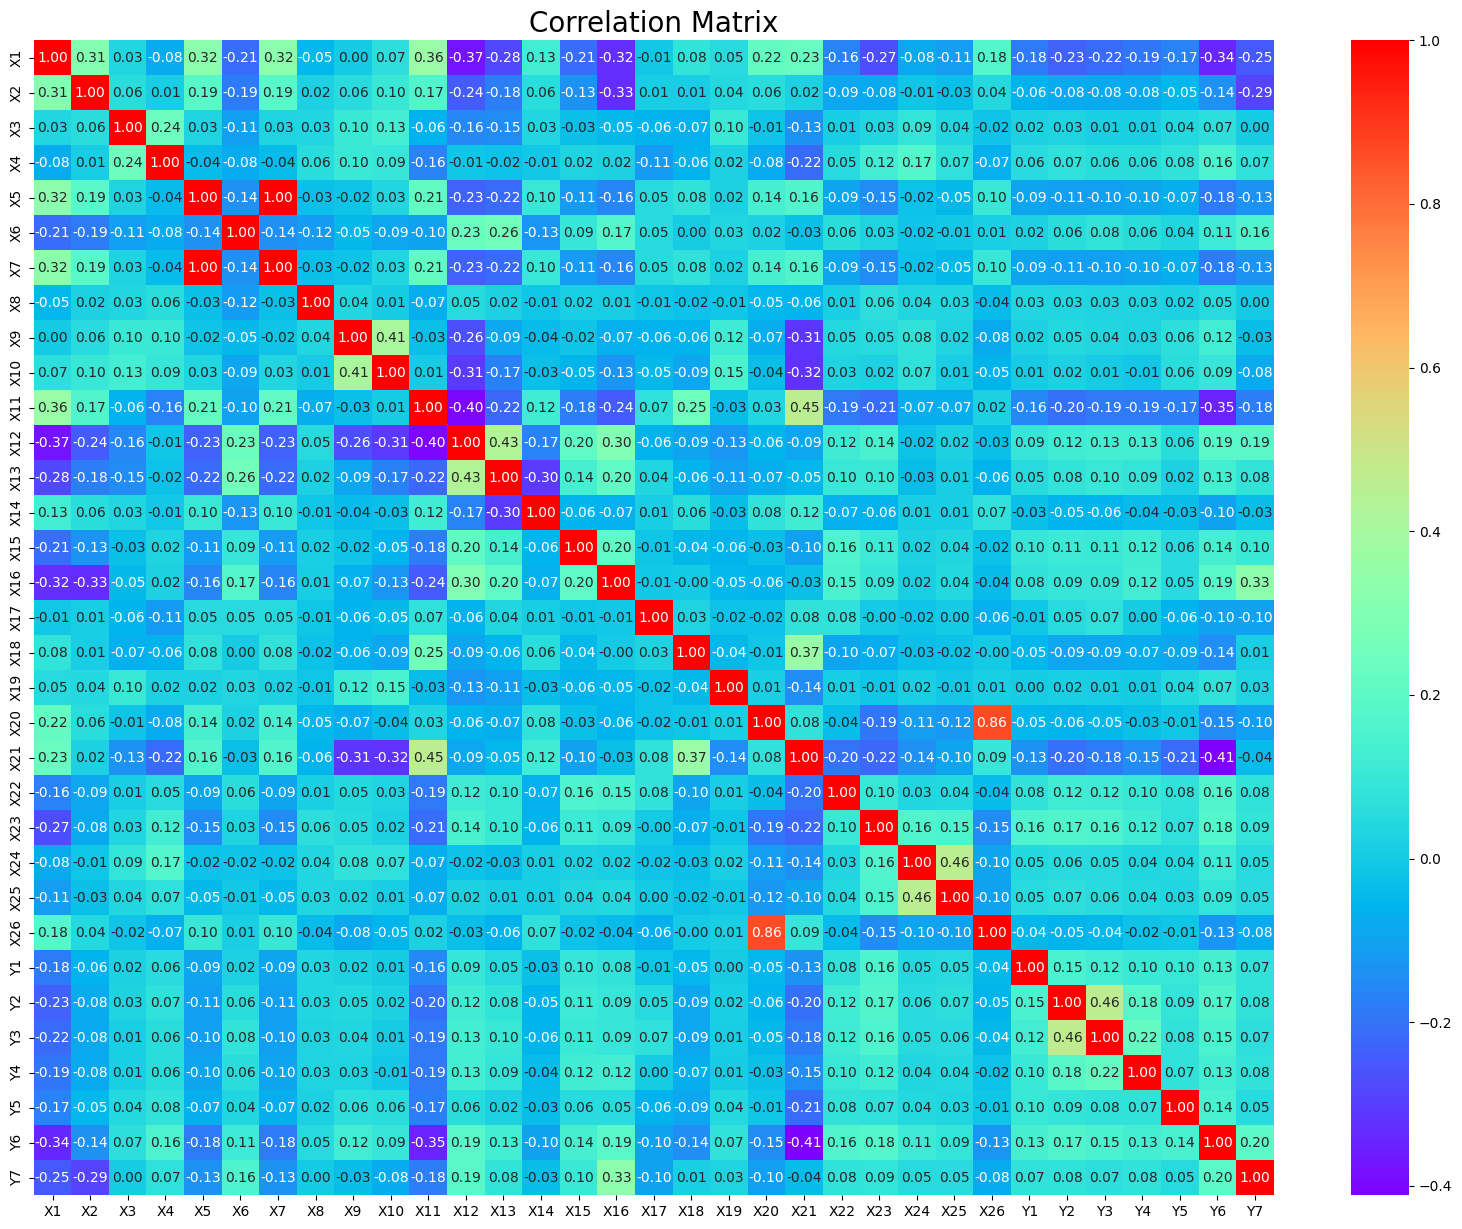

In [3]:
# Correlation matrix graph of the data set
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df_brfss.corr(), annot=True, fmt=".2f", ax=ax, cmap = "rainbow" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [4]:
X

array([[0.21879749, 0.0729325 , 0.0729325 , ..., 0.0729325 , 0.21879749,
        0.0729325 ],
       [0.35007002, 0.21004201, 0.070014  , ..., 0.070014  , 0.14002801,
        0.14002801],
       [0.36214298, 0.09053575, 0.09053575, ..., 0.18107149, 0.27160724,
        0.09053575],
       ...,
       [0.07980869, 0.15961738, 0.07980869, ..., 0.07980869, 0.23942607,
        0.07980869],
       [0.26211122, 0.08737041, 0.17474081, ..., 0.08737041, 0.26211122,
        0.17474081],
       [0.08192319, 0.08192319, 0.08192319, ..., 0.08192319, 0.24576958,
        0.16384638]])

In [5]:
y

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

# Define Binary relevance with DNN Model

In [6]:
# Modify the get_model function to create and compile the base classifier
def get_base_classifier():
    model = Sequential()
    model.add(Dense(26, input_dim=26, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(7, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

base_classifier = get_base_classifier()

In [7]:
# Import the necessary libraries
import copy
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_array

# Create a wrapper class for Keras model to make it behave like an sklearn classifier
class KerasBinaryRelevance(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, epochs=10, verbose=1):
        self.base_classifier = base_classifier
        self.epochs = epochs
        self.verbose = verbose

    def fit(self, X, y):
        self.label_count = y.shape[1]
        self.classifiers_ = []
        for i in range(self.label_count):
            classifier = copy.deepcopy(self.base_classifier)
            y_subset = y[:, i]
            classifier.fit(X, y_subset, epochs=self.epochs, verbose=self.verbose)
            self.classifiers_.append(classifier)
        return self

    def predict(self, X):
        X = check_array(X)
        results = np.zeros((X.shape[0], self.label_count), dtype=int)
        for i, classifier in enumerate(self.classifiers_):
            predictions = classifier.predict(X)
            results[:, i] = (predictions > 0.5).astype(int).flatten()
        return results

# Create the base classifier
base_classifier = get_base_classifier()



In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33) 


In [9]:

# PROBLEM TRANSFORMATION
model = KerasBinaryRelevance(build_fn=lambda: base_classifier, epochs=10, verbose=1)

TypeError: KerasBinaryRelevance.__init__() got an unexpected keyword argument 'build_fn'

# Training Phase not using Cross Validation

In [ ]:
# Train with time
start = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start
print(training_time)

AttributeError: 'Adam' object has no attribute 'build'

In [ ]:
# Testing with time
start = time.time()
# make a prediction on the test set
yhat = model.predict(X_test)
testing_time = time.time() - start

print(testing_time)
yprob=yhat #UNTUK ROC AUC KRITING
# round probabilities to class labels
yhat = yhat.round() #UNTUK EVAL METRIK
#print(yprob[1,])
#print(yhat[1,])

6230/6230 [==============================] - 2s 299us/step
3.071315050125122


# 1. Matrix Evaluation Label Based


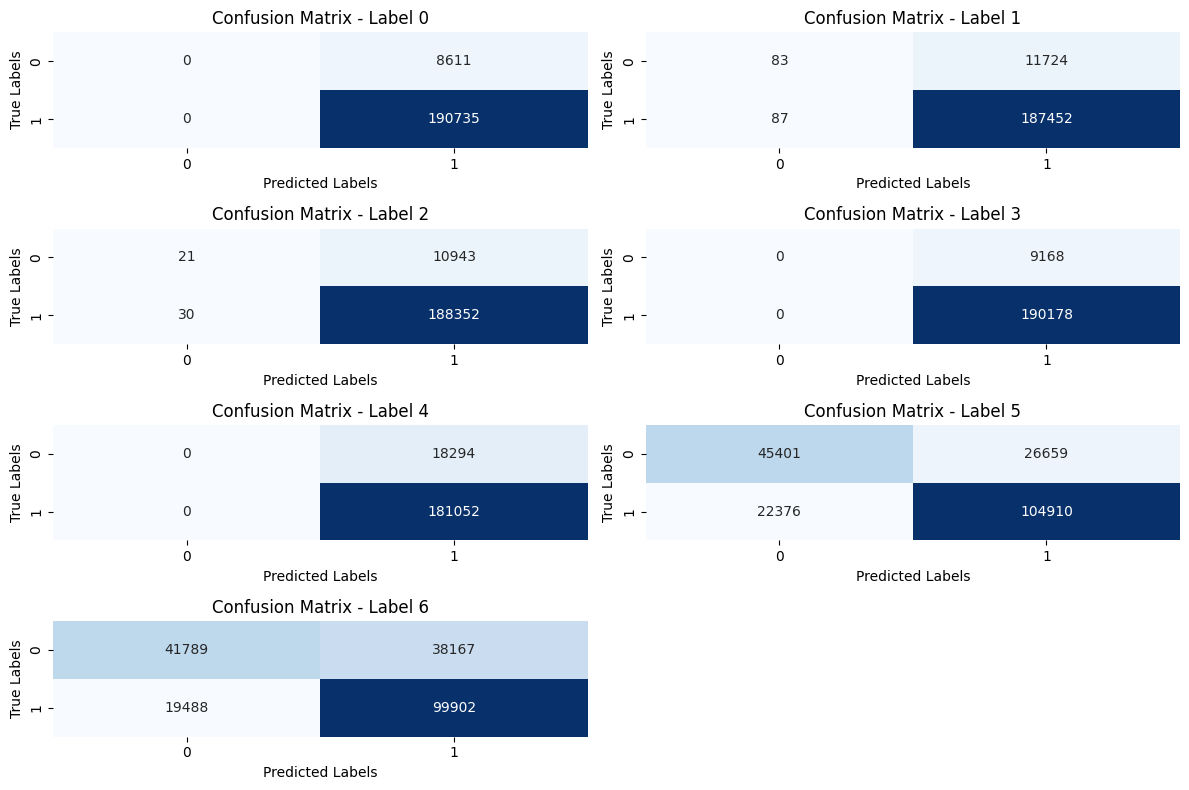

In [ ]:
#hitung CM untuk eval metrik yang lain pre memori

# Multilabel confusion matrix
cm = multilabel_confusion_matrix(y_test, yhat)

# Determine the grid dimensions for subplots
num_labels = cm.shape[0]
cols = min(num_labels, 2)
rows = (num_labels + cols - 1) // cols

# Plot confusion matrix
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
for i, (matrix, ax) in enumerate(zip(cm, axes.ravel())):
    sns.heatmap(matrix, annot=True, fmt="d", cbar=False, cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix - Label {i}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

# Remove unused subplots if necessary
if num_labels < rows * cols:
    for j in range(num_labels, rows * cols):
        fig.delaxes(axes.ravel()[j])

plt.tight_layout()
plt.show()

In [ ]:
# membuat AUC ROC label A
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test[:,1], yprob[:,1])
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.848148494742974


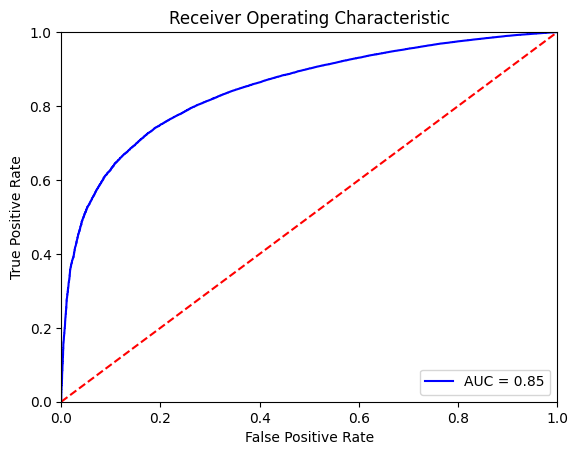

In [ ]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

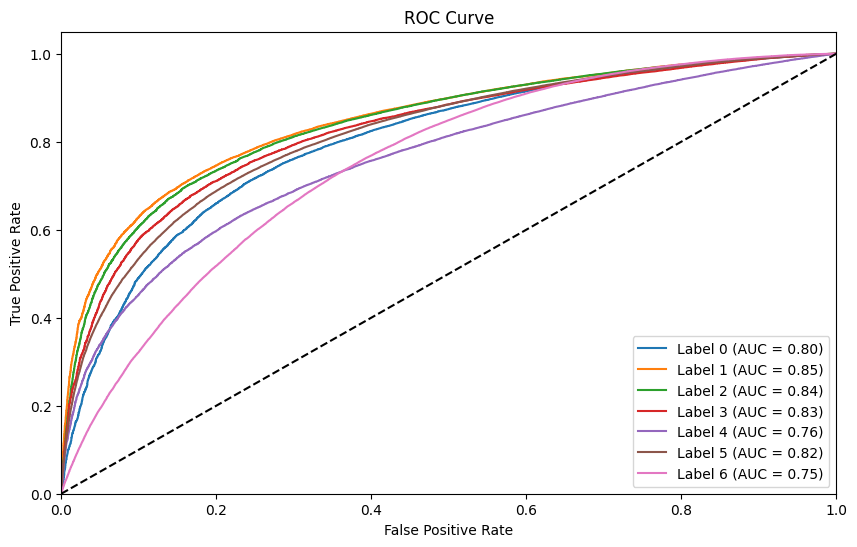

In [ ]:
plt.figure(figsize=(10, 6))
roc_auc_per_label = dict()
#predictions=preds
for i in range(y.shape[1]):
    fpr, tpr, _ = metrics.roc_curve(y_test[:,i], yprob[:,i])
    roc_auc_per_label[i] = metrics.roc_auc_score(y_test[:,i], yprob[:,i])
    plt.plot(fpr, tpr, label='Label %d (AUC = %0.2f)' % (i, roc_auc_per_label[i]))
# Plot ROC curve for each label
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 2. Matrix Evaluation Example Based


In [ ]:
# Evaluation metrics
accuracy = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat, average='micro')
recall = recall_score(y_test, yhat, average='micro')
f1 = f1_score(y_test, yhat, average='micro')
hamming_loss_score = hamming_loss(y_test, yhat)
jaccard = jaccard_score(y_test, yhat, average='micro')
auc_roc = roc_auc_score(y_test, yhat)

In [ ]:
# Print results
print('Training Time:', round(training_time, 2), 'seconds')
print('Testing Time on Specific Test Set:', round(testing_time, 2), 'seconds')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Hamming Loss:', hamming_loss_score)
print('Jaccard Score:', jaccard)
print('AUC-ROC:', auc_roc)

Training Time: 59.79 seconds
Testing Time on Specific Test Set: 3.04 seconds
Accuracy: 0.44788458258505315
Precision: 0.898510848859178
Recall: 0.9694785489691266
F1 Score: 0.9326466145875626
Hamming Loss: 0.11887873345840899
Jaccard Score: 0.8737936538489337
AUC-ROC: 0.5565981509545476


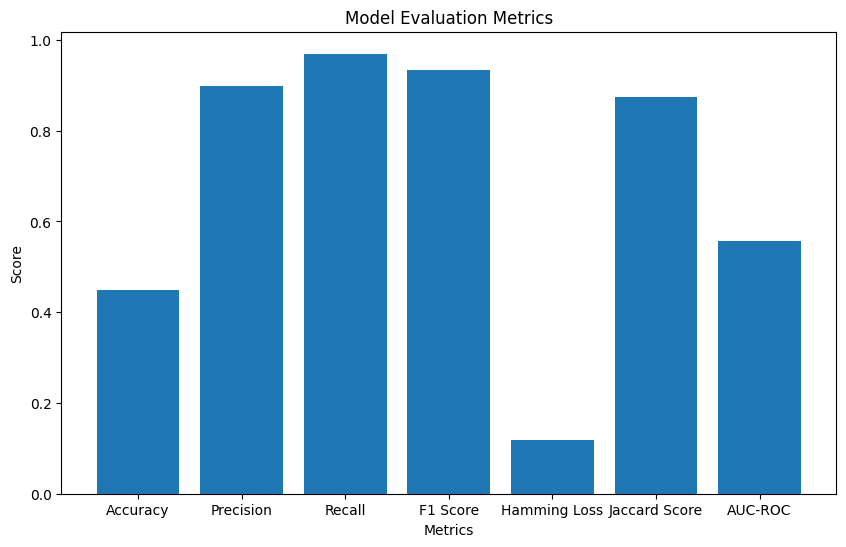

In [ ]:

# Evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Hamming Loss', 'Jaccard Score', 'AUC-ROC']
values = [accuracy, precision, recall, f1, hamming_loss_score, jaccard, auc_roc]

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.show()

In [ ]:
import sklearn.metrics

print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_test, yhat, normalize=True, sample_weight=None)))
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_test, yhat))) 
print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_test, y_pred=yhat, average='samples'))) 
print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_test, y_pred=yhat, average='samples')))
print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_test, y_pred=yhat, average='samples'))) 

Exact Match Ratio: 0.44788458258505315
Hamming loss: 0.11887873345840899
Recall: 0.89540100891821


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9680869419191233
F1 Measure: 0.9233106632648135


In [ ]:
#Subet Accuracy atau Exact Match Ratio
from sklearn.metrics import accuracy_score
accuracy_score(y_test, yhat)

0.44788458258505315

In [ ]:
# HITUNG HAMMING LOSS
from sklearn.metrics import hamming_loss
hamming_loss(y_test, yhat)

0.11887873345840899

In [ ]:
from sklearn.metrics import jaccard_score
print('jaccard_score_Samples: {0}'.format(jaccard_score(y_test, yhat, average='samples')))
print('jaccard_score_Micro: {0}'.format(jaccard_score(y_test, yhat, average="micro")))
print('jaccard_score_Macro: {0}'.format(jaccard_score(y_test, yhat, average="macro")))


jaccard_score_Samples: 0.8714651911751427
jaccard_score_Micro: 0.8737936538489337
jaccard_score_Macro: 0.8616548686464247


In [ ]:
from sklearn.metrics import zero_one_loss
print('Zero_one_loss: {0}'.format(zero_one_loss(y_test, yhat)))
print('Zero_one_loss_Samples: {0}'.format(zero_one_loss(y_test, yhat, normalize=False)))

Zero_one_loss: 0.5521154174149469
Zero_one_loss_Samples: 110062


In [ ]:
from sklearn.metrics import f1_score

print('f1_score_micro: {0}'.format(f1_score(y_test, yhat, average='micro')))
print('f1_score_macro: {0}'.format(f1_score(y_test, yhat, average='macro')))
print('f1_score_weighted: {0}'.format(f1_score(y_test, yhat, average='weighted')))
print('f1_score_none: {0}'.format(f1_score(y_test, yhat, average=None)))


f1_score_micro: 0.9326466145875626
f1_score_macro: 0.9202887311393383
f1_score_weighted: 0.933965661105447
f1_score_none: [0.97773903 0.96980179 0.97196522 0.97674992 0.95226357 0.81204936
 0.78145223]


In [ ]:
from sklearn.metrics import fbeta_score

print('fbeta_macro: {0}'.format(fbeta_score(y_test, yhat, average='macro', beta=0.5)))
print('fbeta_micro: {0}'.format(fbeta_score(y_test, yhat, average='micro', beta=0.5)))
print('fbeta_weighted: {0}'.format(fbeta_score(y_test, yhat, average='weighted', beta=0.5)))
print('fbeta_none: {0}'.format(fbeta_score(y_test, yhat, average=None, beta=0.5)))

fbeta_macro: 0.8994796825133066
fbeta_micro: 0.9118608434409317
fbeta_weighted: 0.9143344830483496
fbeta_none: [0.96485191 0.95277209 0.95604062 0.96331167 0.92574842 0.79860121
 0.73503187]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

print('recision_recall_fscore_support_macro: {0}'.format(precision_recall_fscore_support(y_test, yhat, average='macro')))
print('recision_recall_fscore_support_micro: {0}'.format(precision_recall_fscore_support(y_test, yhat, average='micro')))
print('recision_recall_fscore_support_weighted: {0}'.format(precision_recall_fscore_support(y_test, yhat, average='weighted')))
print('recision_recall_fscore_support_none: {0}'.format(precision_recall_fscore_support(y_test, yhat, average=None)))

recision_recall_fscore_support_macro: (0.886321717966686, 0.9583111559281665, 0.9202887311393383, None)
recision_recall_fscore_support_micro: (0.898510848859178, 0.9694785489691266, 0.9326466145875626, None)
recision_recall_fscore_support_weighted: (0.9018532806300409, 0.9694785489691266, 0.933965661105447, None)
recision_recall_fscore_support_none: (array([0.95644758, 0.94174738, 0.94571099, 0.9545564 , 0.90887703,
       0.78988052, 0.70703213]), array([1.        , 0.99957899, 0.99971878, 1.        , 1.        ,
       0.83549852, 0.8733818 ]), array([0.97773903, 0.96980179, 0.97196522, 0.97674992, 0.95226357,
       0.81204936, 0.78145223]), array([190664, 187644, 188467, 190287, 181181, 127318, 119114]))


In [ ]:
from sklearn.metrics import precision_score
print('precision_score_macro: {0}'.format(precision_score(y_test, yhat, average='macro')))
print('precision_score_micro: {0}'.format(precision_score(y_test, yhat, average='micro')))
print('precision_score_weighted: {0}'.format(precision_score(y_test, yhat, average='weighted')))
print('precision_score_none: {0}'.format(precision_score(y_test, yhat, average=None)))
print('precision_score_zero_divisio: {0}'.format(precision_score(y_test, yhat, average=None, zero_division=1)))


precision_score_macro: 0.886321717966686
precision_score_micro: 0.898510848859178
precision_score_weighted: 0.9018532806300409
precision_score_none: [0.95644758 0.94174738 0.94571099 0.9545564  0.90887703 0.78988052
 0.70703213]
precision_score_zero_divisio: [0.95644758 0.94174738 0.94571099 0.9545564  0.90887703 0.78988052
 0.70703213]


In [ ]:
from sklearn.metrics import recall_score
print('recall_score_macro: {0}'.format(recall_score(y_test, yhat, average='macro')))
print('recall_score_micro: {0}'.format(recall_score(y_test, yhat, average='micro')))
print('recall_score_weighted: {0}'.format(recall_score(y_test, yhat, average='weighted')))
print('recall_score_none: {0}'.format(recall_score(y_test, yhat, average=None)))
print('recall_score_zero_divisio: {0}'.format(recall_score(y_test, yhat, average=None, zero_division=1)))


recall_score_macro: 0.9583111559281665
recall_score_micro: 0.9694785489691266
recall_score_weighted: 0.9694785489691266
recall_score_none: [1.         0.99957899 0.99971878 1.         1.         0.83549852
 0.8733818 ]
recall_score_zero_divisio: [1.         0.99957899 0.99971878 1.         1.         0.83549852
 0.8733818 ]


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, yhat)

array([[[     0,   8682],
        [     0, 190664]],

       [[   100,  11602],
        [    79, 187565]],

       [[    63,  10816],
        [    53, 188414]],

       [[     0,   9059],
        [     0, 190287]],

       [[     0,  18165],
        [     0, 181181]],

       [[ 43731,  28297],
        [ 20944, 106374]],

       [[ 37125,  43107],
        [ 15082, 104032]]])

In [ ]:
# CLASSIFICATION REPORT : precision, recacll f1-score support every label
from sklearn.metrics import classification_report 
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    190664
           1       0.94      1.00      0.97    187644
           2       0.95      1.00      0.97    188467
           3       0.95      1.00      0.98    190287
           4       0.91      1.00      0.95    181181
           5       0.79      0.84      0.81    127318
           6       0.71      0.87      0.78    119114

   micro avg       0.90      0.97      0.93   1184675
   macro avg       0.89      0.96      0.92   1184675
weighted avg       0.90      0.97      0.93   1184675
 samples avg       0.90      0.97      0.92   1184675



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Actual \n", y_test)
print("\nPredicted \n", yhat)

Actual 
 [[1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 0]]

Predicted 
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 0. 0.]]


# TRAIN DNN MODEL USING 10-Fold Cross-Validation for validate

In [ ]:
# 10-fold cross-validation
from sklearn.model_selection import KFold

# Initialize KFold cross-validation
kf = KFold(n_splits=10)

start = time.time()
predicted_labels = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the Keras model to the current fold's training data
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Obtain predictions for the current fold's test data
    fold_predictions = model.predict(X_test)
    predicted_labels.append(fold_predictions)

# Concatenate the predictions from all folds
predicted_labels = np.concatenate(predicted_labels)
cross_val_time = time.time() - start


1888/1888 [==============================] - 1s 301us/step


In [ ]:
# Testing with time
start = time.time()
# make a prediction on the test set
yhat = model.predict(X_test)
testing_time = time.time() - start

print(testing_time)
yprob=yhat #UNTUK ROC AUC KRITING
# round probabilities to class labels
yhat = yhat.round() #UNTUK EVAL METRIK
#print(yprob[1,])
#print(yhat[1,])

1888/1888 [==============================] - 1s 299us/step
0.8039219379425049


# 1. Matrix Evaluation Label Based


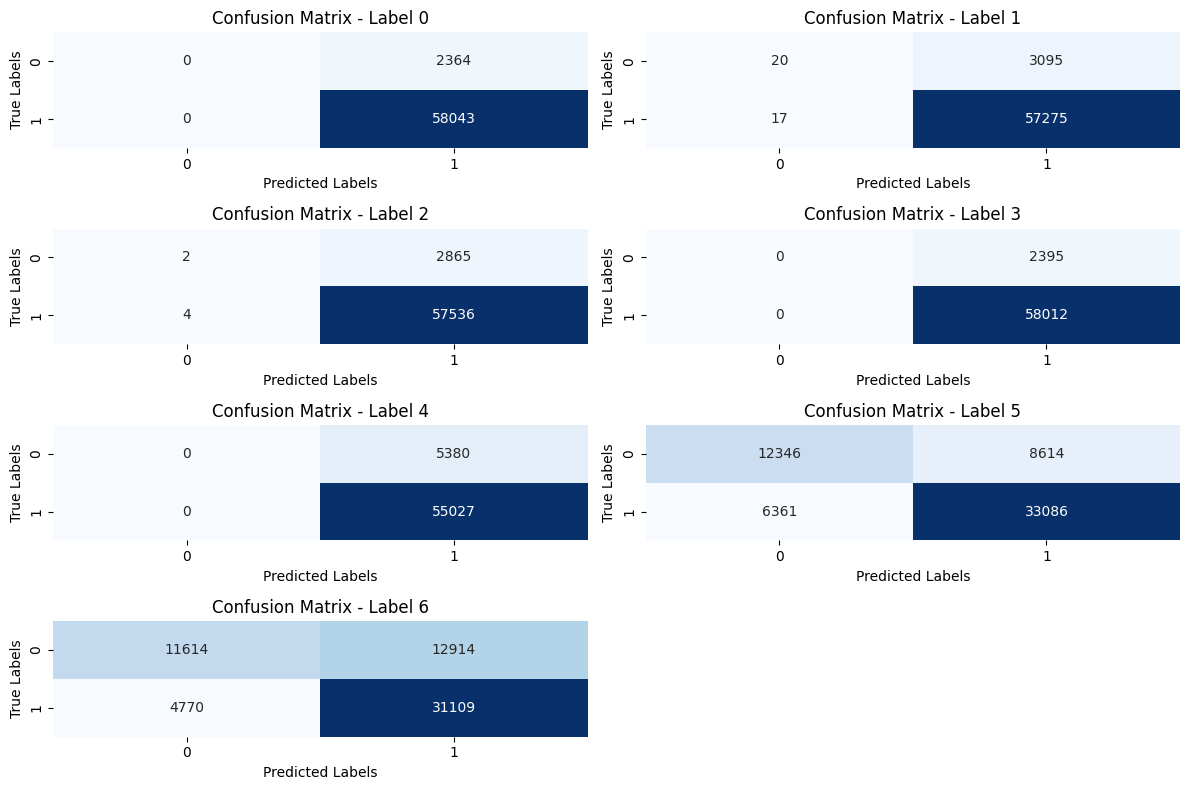

In [ ]:
#hitung CM untuk eval metrik yang lain pre memori

# Multilabel confusion matrix
cm = multilabel_confusion_matrix(y_test, yhat)

# Determine the grid dimensions for subplots
num_labels = cm.shape[0]
cols = min(num_labels, 2)
rows = (num_labels + cols - 1) // cols

# Plot confusion matrix
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
for i, (matrix, ax) in enumerate(zip(cm, axes.ravel())):
    sns.heatmap(matrix, annot=True, fmt="d", cbar=False, cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix - Label {i}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

# Remove unused subplots if necessary
if num_labels < rows * cols:
    for j in range(num_labels, rows * cols):
        fig.delaxes(axes.ravel()[j])

plt.tight_layout()
plt.show()


In [ ]:
# membuat AUC ROC label A
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test[:,1], yprob[:,1])
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.8558149661966538


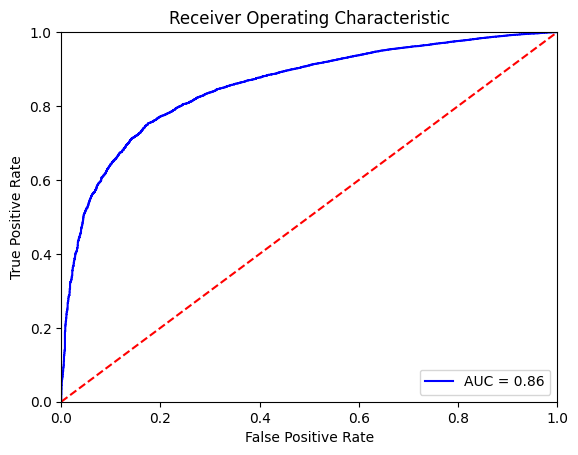

In [ ]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

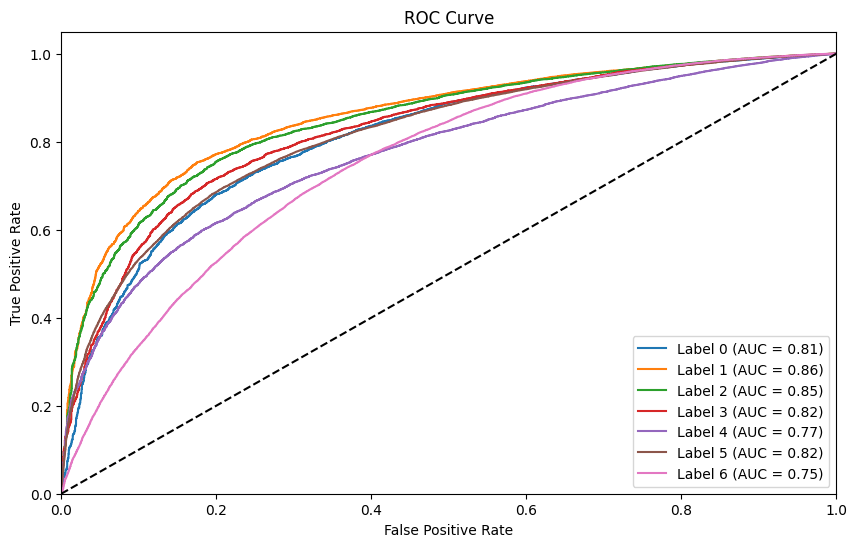

In [ ]:
plt.figure(figsize=(10, 6))
roc_auc_per_label = dict()
#predictions=preds
for i in range(y.shape[1]):
    fpr, tpr, _ = metrics.roc_curve(y_test[:,i], yprob[:,i])
    roc_auc_per_label[i] = metrics.roc_auc_score(y_test[:,i], yprob[:,i])
    plt.plot(fpr, tpr, label='Label %d (AUC = %0.2f)' % (i, roc_auc_per_label[i]))
# Plot ROC curve for each label
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Get the parameter values
#params = model.get_params()

# Print the parameter values
#print(params)

In [ ]:
# Initialize KFold cross-validation
kf = KFold(n_splits=10)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_hamming_losses = []
fold_jaccard_scores = []
fold_roc_aucs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = get_model(n_inputs=26, n_outputs=7)

    # Fit the Keras model to the current fold's training data
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # make a prediction on the test set
    y_prob = model.predict(X_test)
    y_hat = y_prob.round()


1888/1888 [==============================] - 1s 284us/step


In [ ]:
# Calculate evaluation metrics for the current fold
fold_accuracy = accuracy_score(y_test, y_hat)
fold_precision = precision_score(y_test, y_hat, average='macro')
fold_recall = recall_score(y_test, y_hat, average='macro')
fold_f1_score = f1_score(y_test, y_hat, average='macro')
fold_hamming_loss = hamming_loss(y_test, y_hat)
fold_jaccard_score = jaccard_score(y_test, y_hat, average='macro')
fold_roc_auc = roc_auc_score(y_test, y_prob, average='macro', multi_class='ovr')

# Store metrics for the current fold
fold_accuracies.append(fold_accuracy)
fold_precisions.append(fold_precision)
fold_recalls.append(fold_recall)
fold_f1_scores.append(fold_f1_score)
fold_hamming_losses.append(fold_hamming_loss)
fold_jaccard_scores.append(fold_jaccard_score)
fold_roc_aucs.append(fold_roc_auc)



In [ ]:
# Print average metrics across all folds
print("Average Accuracy:", np.mean(fold_accuracies))
print("Average Precision:", np.mean(fold_precisions))
print("Average Recall:", np.mean(fold_recalls))
print("Average F1 Score:", np.mean(fold_f1_scores))
print("Average Hamming Loss:", np.mean(fold_hamming_losses))
print("Average Jaccard Score:", np.mean(fold_jaccard_scores))
print("Average ROC AUC:", np.mean(fold_roc_aucs))


Average Accuracy: 0.4538546857152317
Average Precision: 0.8894382705240841
Average Recall: 0.9594605344877735
Average F1 Score: 0.922528505130505
Average Hamming Loss: 0.11553060312310068
Average Jaccard Score: 0.8658340702442586
Average ROC AUC: 0.8085354338061348


In [ ]:
import joblib
# Save the model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model to binary format (joblib)
joblib.dump(model, "model.bin")

['model.bin']

# 2. Matrix Evaluation Example Based


In [ ]:
# Evaluation metrics
accuracy = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat, average='micro')
recall = recall_score(y_test, yhat, average='micro')
f1 = f1_score(y_test, yhat, average='micro')
hamming_loss_score = hamming_loss(y_test, yhat)
jaccard = jaccard_score(y_test, yhat, average='micro')
auc_roc = roc_auc_score(y_test, yhat)

In [ ]:
# Print results
print('Training Time:', round(training_time, 2), 'seconds')
print('Testing Time on Specific Test Set:', round(testing_time, 2), 'seconds')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Hamming Loss:', hamming_loss_score)
print('Jaccard Score:', jaccard)
print('AUC-ROC:', auc_roc)

Training Time: 59.79 seconds
Testing Time on Specific Test Set: 3.04 seconds
Accuracy: 0.44788458258505315
Precision: 0.898510848859178
Recall: 0.9694785489691266
F1 Score: 0.9326466145875626
Hamming Loss: 0.11887873345840899
Jaccard Score: 0.8737936538489337
AUC-ROC: 0.5565981509545476


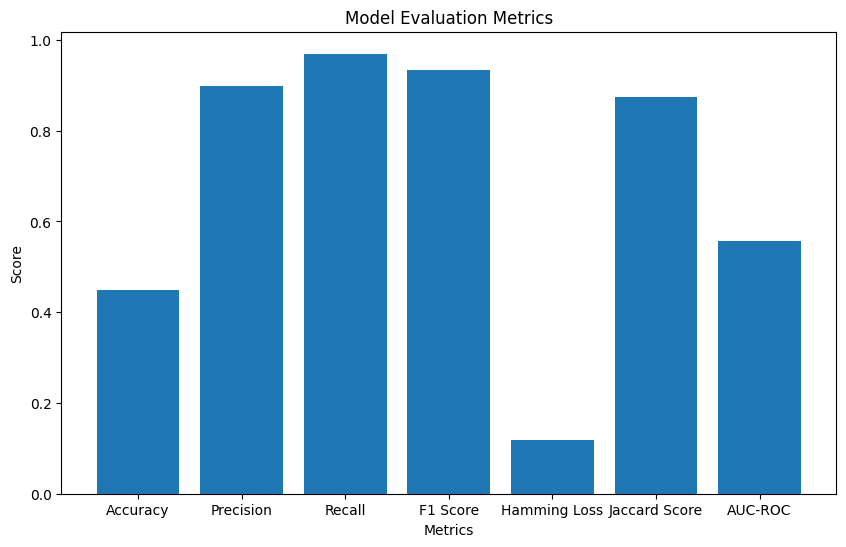

In [ ]:

# Evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Hamming Loss', 'Jaccard Score', 'AUC-ROC']
values = [accuracy, precision, recall, f1, hamming_loss_score, jaccard, auc_roc]

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.show()

In [ ]:
import sklearn.metrics

print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_test, yhat, normalize=True, sample_weight=None)))
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_test, yhat))) 
print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_test, y_pred=yhat, average='samples'))) 
print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_test, y_pred=yhat, average='samples')))
print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_test, y_pred=yhat, average='samples'))) 

Exact Match Ratio: 0.44788458258505315
Hamming loss: 0.11887873345840899
Recall: 0.89540100891821


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9680869419191233
F1 Measure: 0.9233106632648135


In [ ]:
#Subet Accuracy atau Exact Match Ratio
from sklearn.metrics import accuracy_score
accuracy_score(y_test, yhat)

0.44788458258505315

In [ ]:
# HITUNG HAMMING LOSS
from sklearn.metrics import hamming_loss
hamming_loss(y_test, yhat)

0.11887873345840899

In [ ]:
from sklearn.metrics import jaccard_score
print('jaccard_score_Samples: {0}'.format(jaccard_score(y_test, yhat, average='samples')))
print('jaccard_score_Micro: {0}'.format(jaccard_score(y_test, yhat, average="micro")))
print('jaccard_score_Macro: {0}'.format(jaccard_score(y_test, yhat, average="macro")))


jaccard_score_Samples: 0.8714651911751427
jaccard_score_Micro: 0.8737936538489337
jaccard_score_Macro: 0.8616548686464247


In [ ]:
from sklearn.metrics import zero_one_loss
print('Zero_one_loss: {0}'.format(zero_one_loss(y_test, yhat)))
print('Zero_one_loss_Samples: {0}'.format(zero_one_loss(y_test, yhat, normalize=False)))

Zero_one_loss: 0.5521154174149469
Zero_one_loss_Samples: 110062


In [ ]:
from sklearn.metrics import f1_score

print('f1_score_micro: {0}'.format(f1_score(y_test, yhat, average='micro')))
print('f1_score_macro: {0}'.format(f1_score(y_test, yhat, average='macro')))
print('f1_score_weighted: {0}'.format(f1_score(y_test, yhat, average='weighted')))
print('f1_score_none: {0}'.format(f1_score(y_test, yhat, average=None)))


f1_score_micro: 0.9326466145875626
f1_score_macro: 0.9202887311393383
f1_score_weighted: 0.933965661105447
f1_score_none: [0.97773903 0.96980179 0.97196522 0.97674992 0.95226357 0.81204936
 0.78145223]


In [ ]:
from sklearn.metrics import fbeta_score

print('fbeta_macro: {0}'.format(fbeta_score(y_test, yhat, average='macro', beta=0.5)))
print('fbeta_micro: {0}'.format(fbeta_score(y_test, yhat, average='micro', beta=0.5)))
print('fbeta_weighted: {0}'.format(fbeta_score(y_test, yhat, average='weighted', beta=0.5)))
print('fbeta_none: {0}'.format(fbeta_score(y_test, yhat, average=None, beta=0.5)))

fbeta_macro: 0.8994796825133066
fbeta_micro: 0.9118608434409317
fbeta_weighted: 0.9143344830483496
fbeta_none: [0.96485191 0.95277209 0.95604062 0.96331167 0.92574842 0.79860121
 0.73503187]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

print('recision_recall_fscore_support_macro: {0}'.format(precision_recall_fscore_support(y_test, yhat, average='macro')))
print('recision_recall_fscore_support_micro: {0}'.format(precision_recall_fscore_support(y_test, yhat, average='micro')))
print('recision_recall_fscore_support_weighted: {0}'.format(precision_recall_fscore_support(y_test, yhat, average='weighted')))
print('recision_recall_fscore_support_none: {0}'.format(precision_recall_fscore_support(y_test, yhat, average=None)))

recision_recall_fscore_support_macro: (0.886321717966686, 0.9583111559281665, 0.9202887311393383, None)
recision_recall_fscore_support_micro: (0.898510848859178, 0.9694785489691266, 0.9326466145875626, None)
recision_recall_fscore_support_weighted: (0.9018532806300409, 0.9694785489691266, 0.933965661105447, None)
recision_recall_fscore_support_none: (array([0.95644758, 0.94174738, 0.94571099, 0.9545564 , 0.90887703,
       0.78988052, 0.70703213]), array([1.        , 0.99957899, 0.99971878, 1.        , 1.        ,
       0.83549852, 0.8733818 ]), array([0.97773903, 0.96980179, 0.97196522, 0.97674992, 0.95226357,
       0.81204936, 0.78145223]), array([190664, 187644, 188467, 190287, 181181, 127318, 119114]))


In [ ]:
from sklearn.metrics import precision_score
print('precision_score_macro: {0}'.format(precision_score(y_test, yhat, average='macro')))
print('precision_score_micro: {0}'.format(precision_score(y_test, yhat, average='micro')))
print('precision_score_weighted: {0}'.format(precision_score(y_test, yhat, average='weighted')))
print('precision_score_none: {0}'.format(precision_score(y_test, yhat, average=None)))
print('precision_score_zero_divisio: {0}'.format(precision_score(y_test, yhat, average=None, zero_division=1)))


precision_score_macro: 0.886321717966686
precision_score_micro: 0.898510848859178
precision_score_weighted: 0.9018532806300409
precision_score_none: [0.95644758 0.94174738 0.94571099 0.9545564  0.90887703 0.78988052
 0.70703213]
precision_score_zero_divisio: [0.95644758 0.94174738 0.94571099 0.9545564  0.90887703 0.78988052
 0.70703213]


In [ ]:
from sklearn.metrics import recall_score
print('recall_score_macro: {0}'.format(recall_score(y_test, yhat, average='macro')))
print('recall_score_micro: {0}'.format(recall_score(y_test, yhat, average='micro')))
print('recall_score_weighted: {0}'.format(recall_score(y_test, yhat, average='weighted')))
print('recall_score_none: {0}'.format(recall_score(y_test, yhat, average=None)))
print('recall_score_zero_divisio: {0}'.format(recall_score(y_test, yhat, average=None, zero_division=1)))


recall_score_macro: 0.9583111559281665
recall_score_micro: 0.9694785489691266
recall_score_weighted: 0.9694785489691266
recall_score_none: [1.         0.99957899 0.99971878 1.         1.         0.83549852
 0.8733818 ]
recall_score_zero_divisio: [1.         0.99957899 0.99971878 1.         1.         0.83549852
 0.8733818 ]


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, yhat)

array([[[     0,   8682],
        [     0, 190664]],

       [[   100,  11602],
        [    79, 187565]],

       [[    63,  10816],
        [    53, 188414]],

       [[     0,   9059],
        [     0, 190287]],

       [[     0,  18165],
        [     0, 181181]],

       [[ 43731,  28297],
        [ 20944, 106374]],

       [[ 37125,  43107],
        [ 15082, 104032]]])

In [ ]:
# CLASSIFICATION REPORT : precision, recacll f1-score support every label
from sklearn.metrics import classification_report 
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    190664
           1       0.94      1.00      0.97    187644
           2       0.95      1.00      0.97    188467
           3       0.95      1.00      0.98    190287
           4       0.91      1.00      0.95    181181
           5       0.79      0.84      0.81    127318
           6       0.71      0.87      0.78    119114

   micro avg       0.90      0.97      0.93   1184675
   macro avg       0.89      0.96      0.92   1184675
weighted avg       0.90      0.97      0.93   1184675
 samples avg       0.90      0.97      0.92   1184675



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Actual \n", y_test)
print("\nPredicted \n", yhat)

Actual 
 [[1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 0]]

Predicted 
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 0. 0.]]
